#Ankush Dey  ,  Roll:- MDS202108
#Anjali Pugalia , Roll:- MDS202107
#Ritirupa Dey , Roll:- MDS202136

###1. The Fashion MNIST dataset consists of 28x28 grayscale images from 10 categories of images of clothes, shoes etc. Construct a variational autoencoder for them.
###https://www.kaggle.com/datasets/zalando-research/fashionmnist
###- Show 5 examples of images produced by random samples from the latent space
###- Show 5 examples of transitions between two images in the dataset, as we saw in class.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Loading the data

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=img_transform),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=img_transform),
    batch_size=32, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [3]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):   
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

### VAE Model

In [4]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d #latent dimension
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # we have mean and variance, each is d-dim vector
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img

### Loss Function

In [5]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

### Training the VAE

====> Test set loss: 537.4581


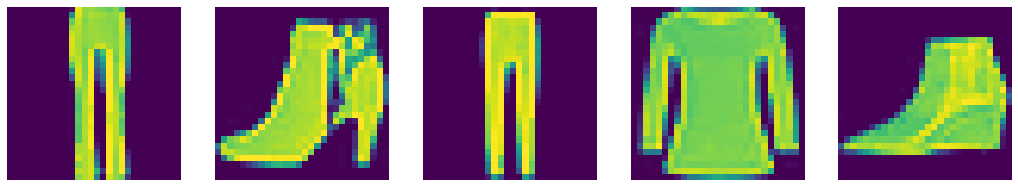

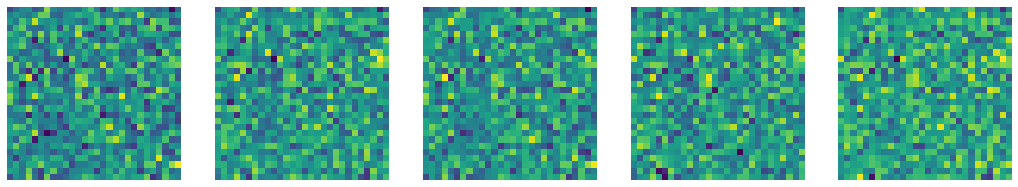

====> Epoch: 1 Average loss: 119.1925
====> Test set loss: 77.3205


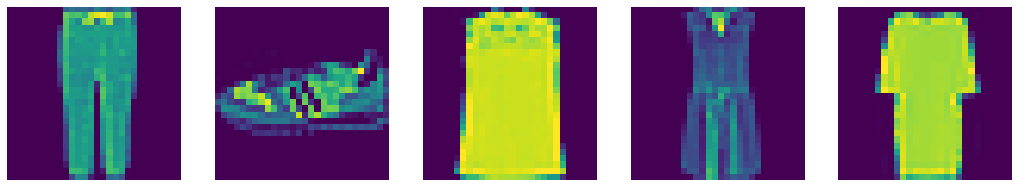

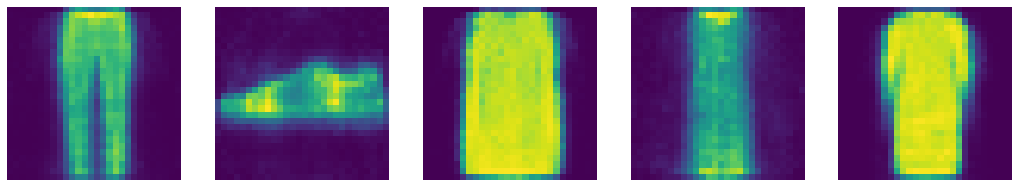

====> Epoch: 2 Average loss: 79.8988
====> Test set loss: 69.4224


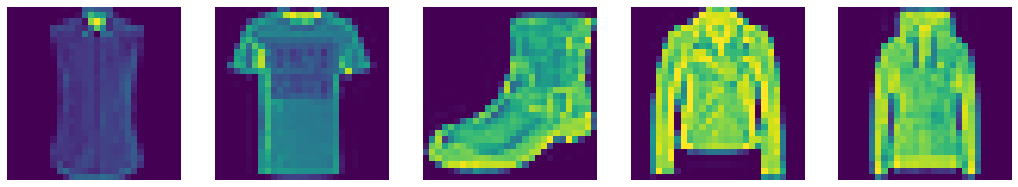

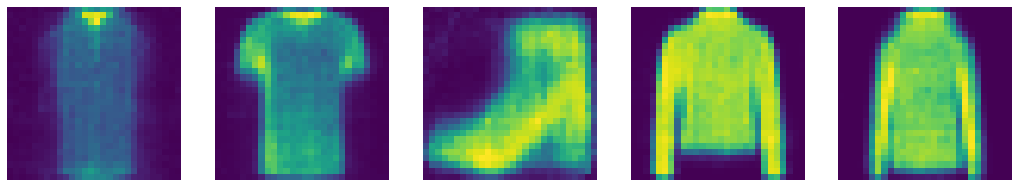

====> Epoch: 3 Average loss: 74.2648
====> Test set loss: 65.8141


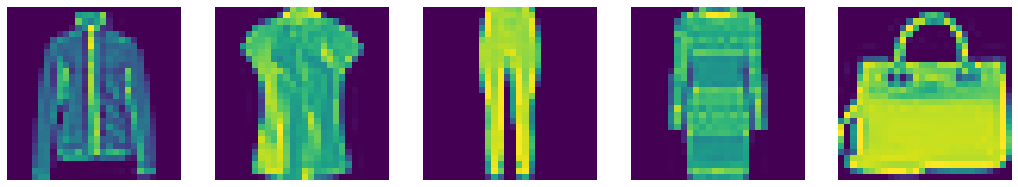

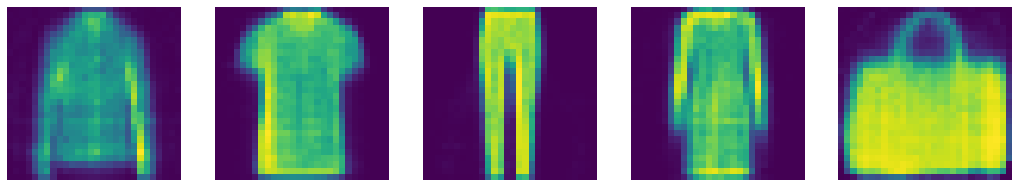

====> Epoch: 4 Average loss: 71.6266
====> Test set loss: 63.4292


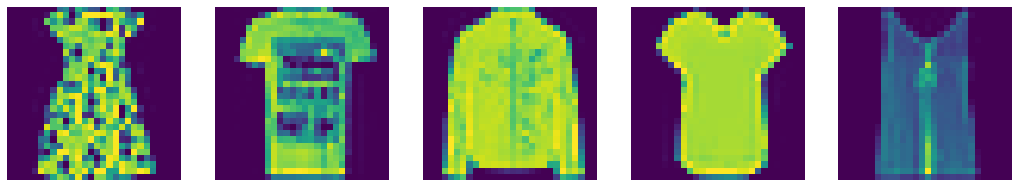

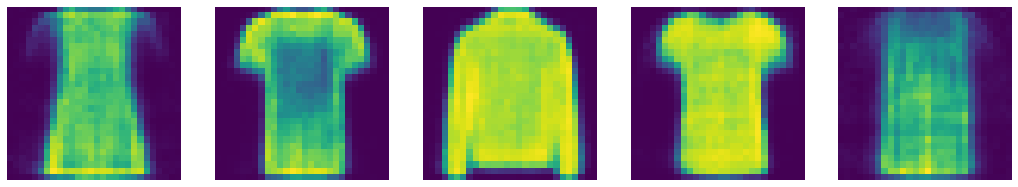

====> Epoch: 5 Average loss: 69.9124
====> Test set loss: 63.1101


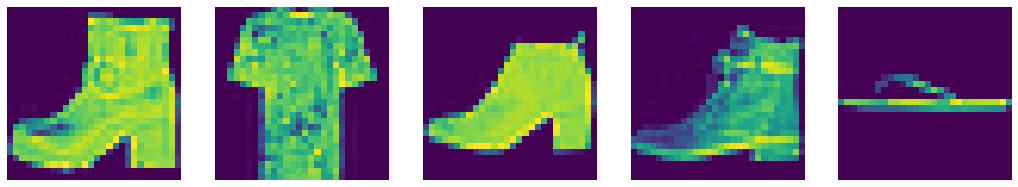

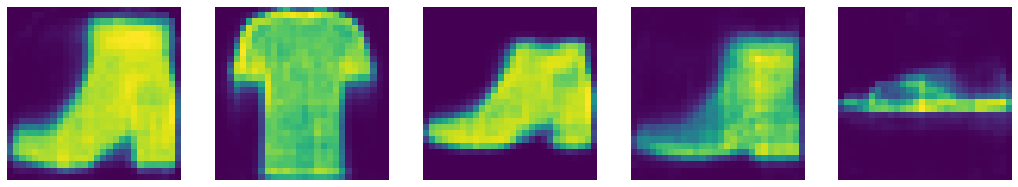

====> Epoch: 6 Average loss: 68.6507
====> Test set loss: 61.4501


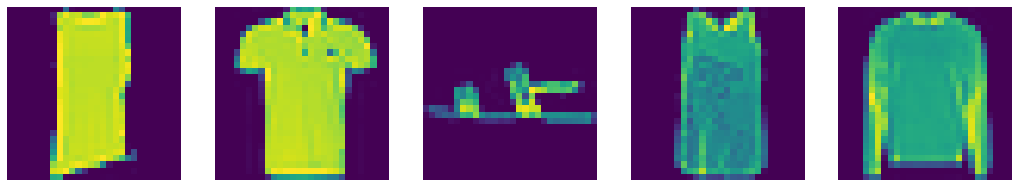

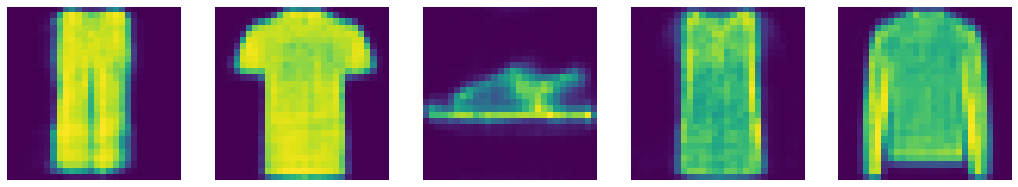

====> Epoch: 7 Average loss: 67.7037
====> Test set loss: 60.7466


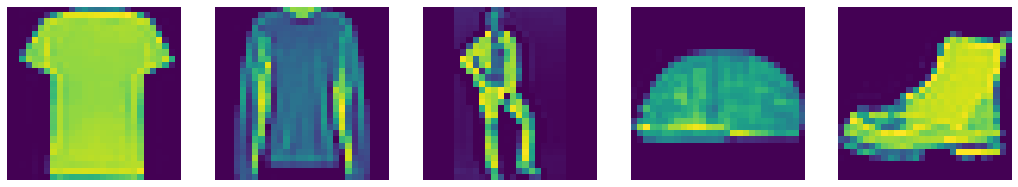

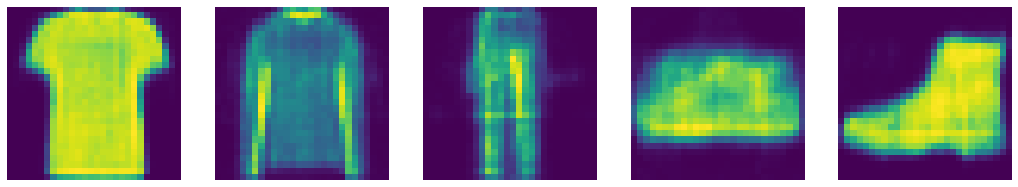

====> Epoch: 8 Average loss: 67.0033
====> Test set loss: 59.5882


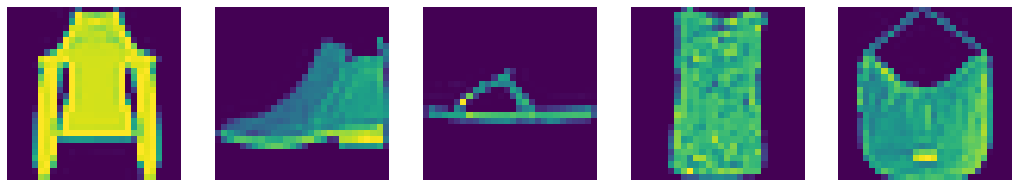

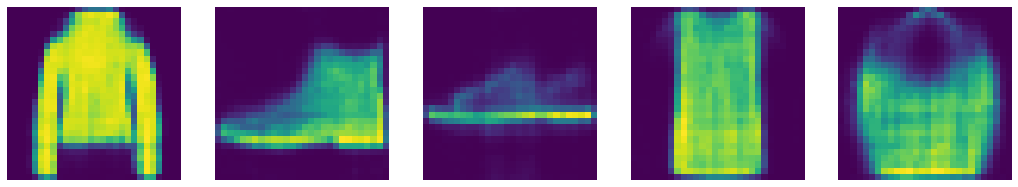

====> Epoch: 9 Average loss: 66.3828
====> Test set loss: 59.5547


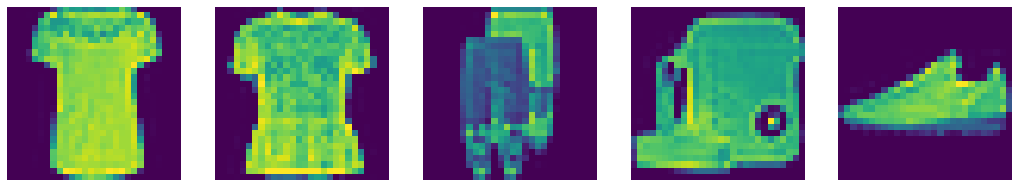

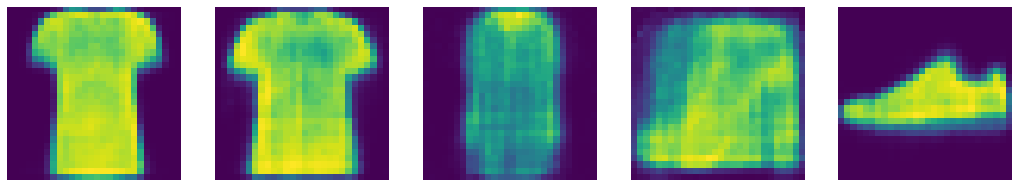

====> Epoch: 10 Average loss: 65.9104
====> Test set loss: 59.2830


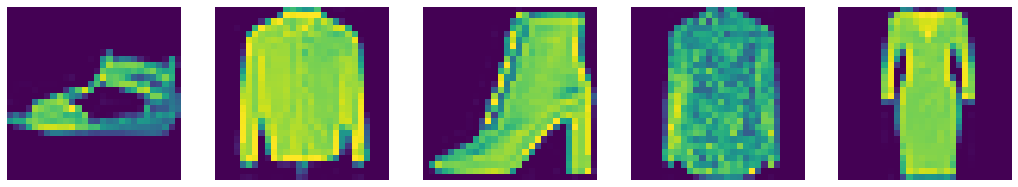

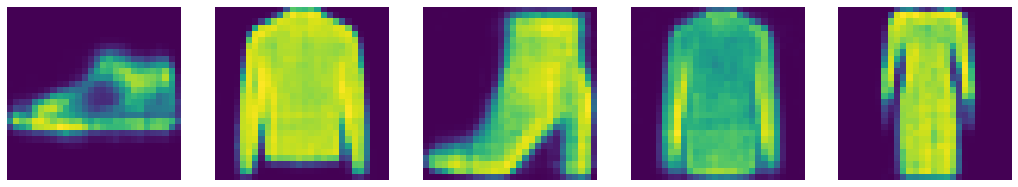

====> Epoch: 11 Average loss: 65.3939
====> Test set loss: 59.2706


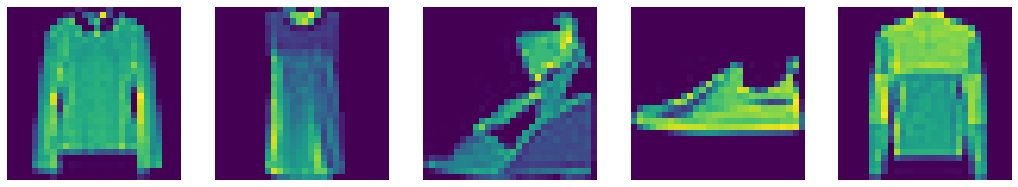

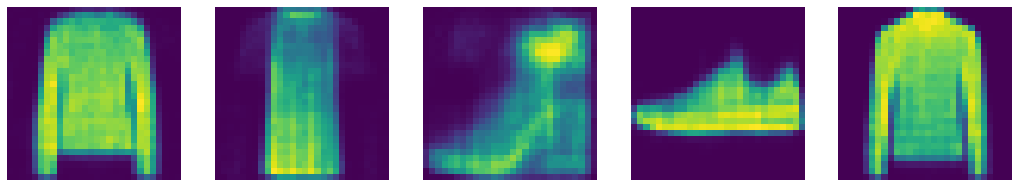

====> Epoch: 12 Average loss: 65.0773
====> Test set loss: 58.7153


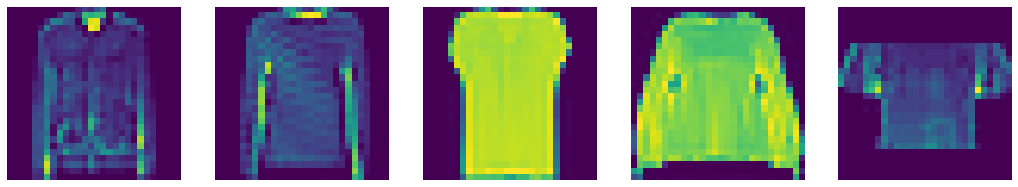

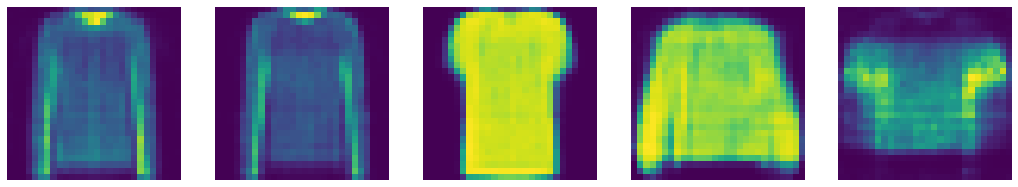

====> Epoch: 13 Average loss: 64.7158
====> Test set loss: 58.0354


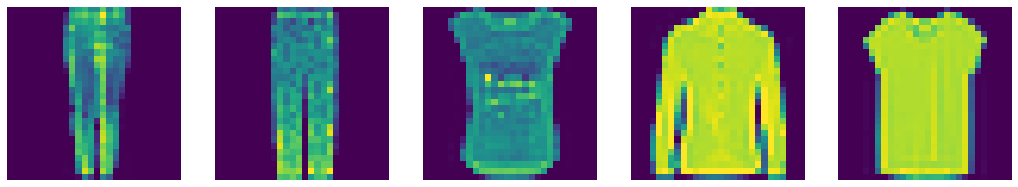

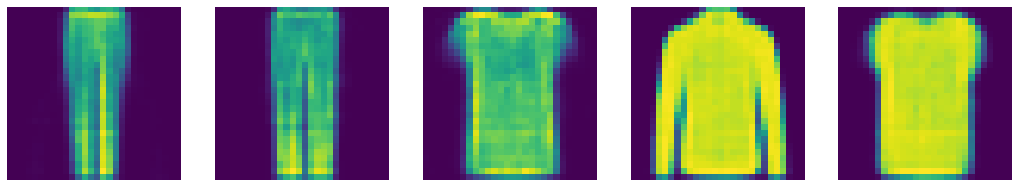

====> Epoch: 14 Average loss: 64.3859
====> Test set loss: 58.3992


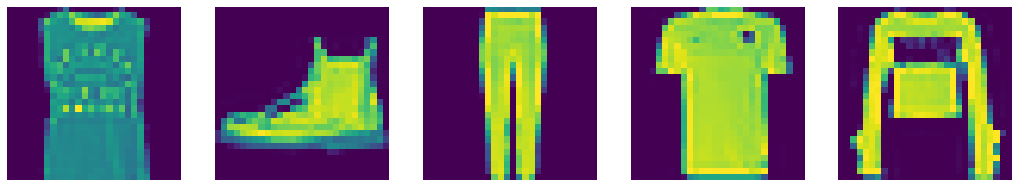

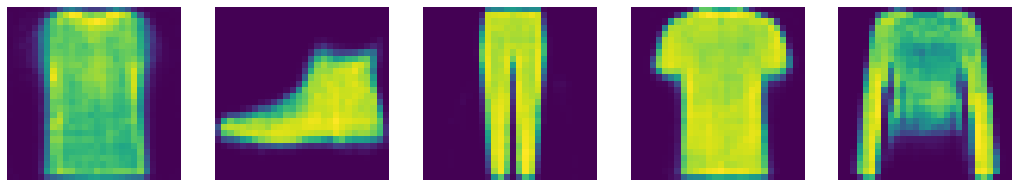

====> Epoch: 15 Average loss: 64.1021
====> Test set loss: 58.4075


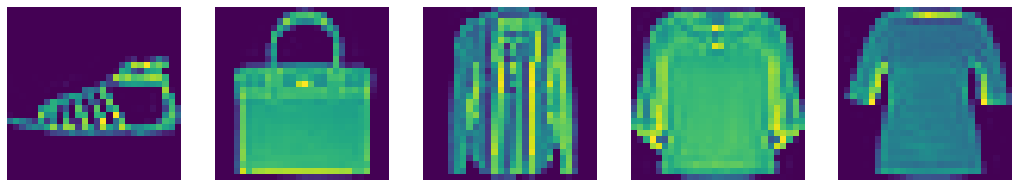

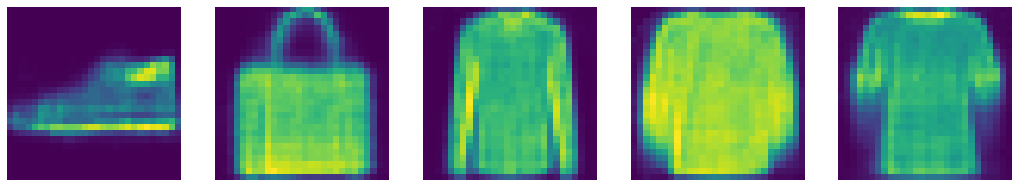

====> Epoch: 16 Average loss: 63.7862
====> Test set loss: 57.3828


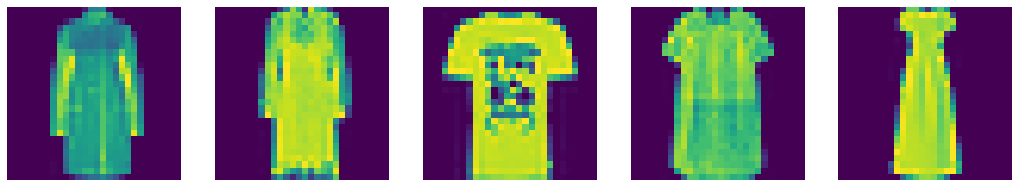

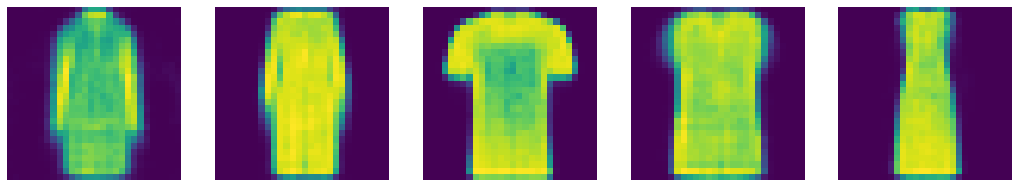

====> Epoch: 17 Average loss: 63.6131
====> Test set loss: 57.1397


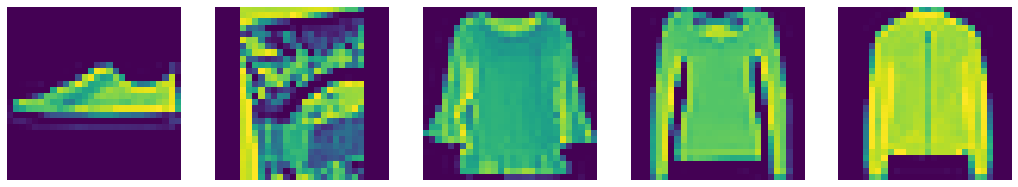

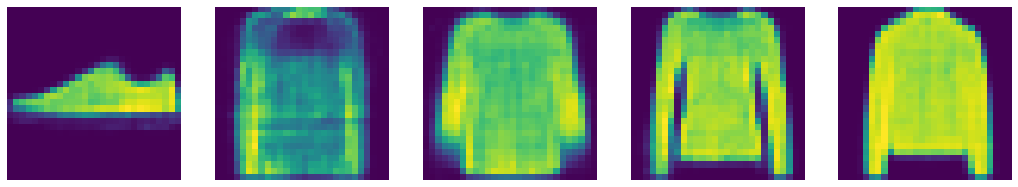

====> Epoch: 18 Average loss: 63.3174
====> Test set loss: 57.1899


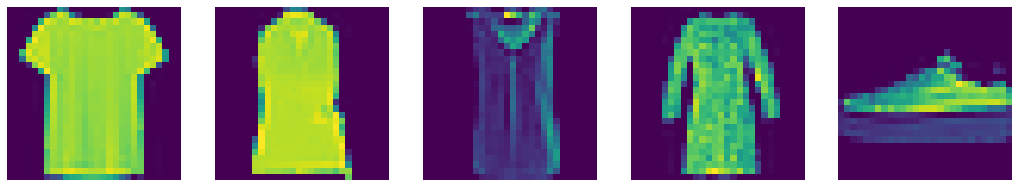

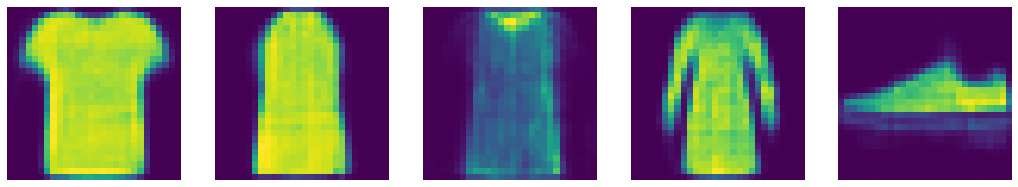

====> Epoch: 19 Average loss: 63.1081
====> Test set loss: 56.8312


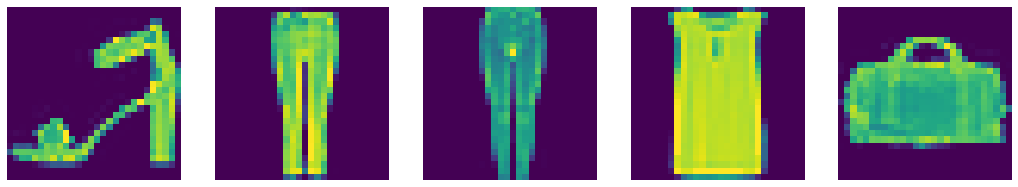

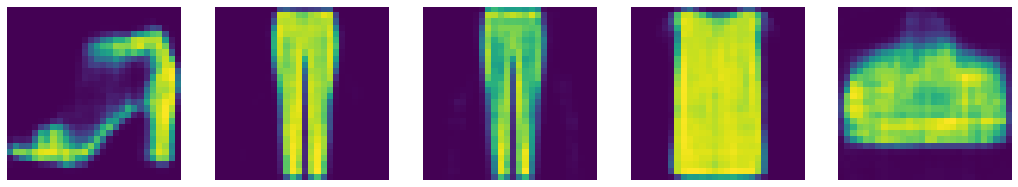

====> Epoch: 20 Average loss: 62.9641
====> Test set loss: 56.5426


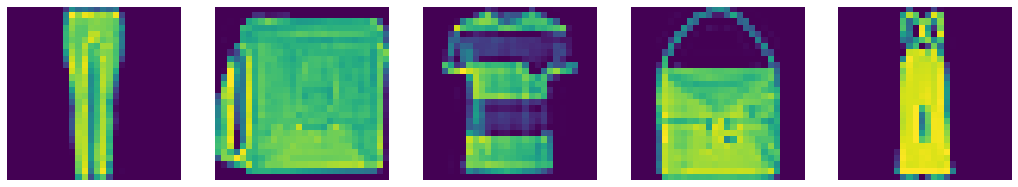

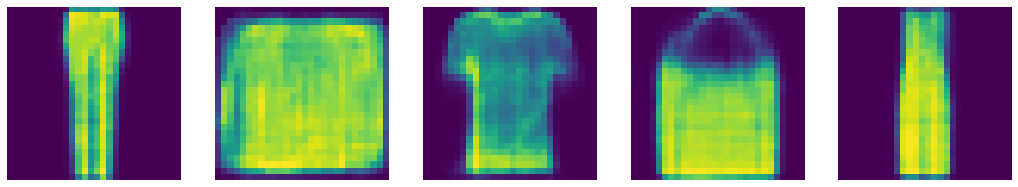

====> Epoch: 21 Average loss: 62.7707
====> Test set loss: 56.5258


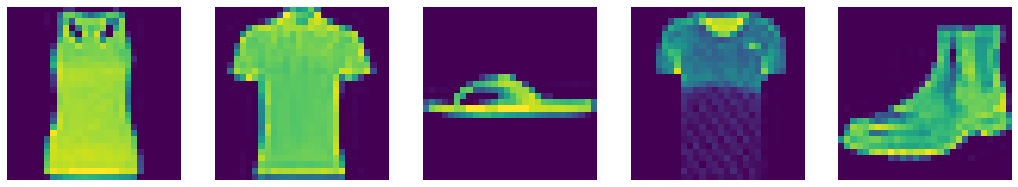

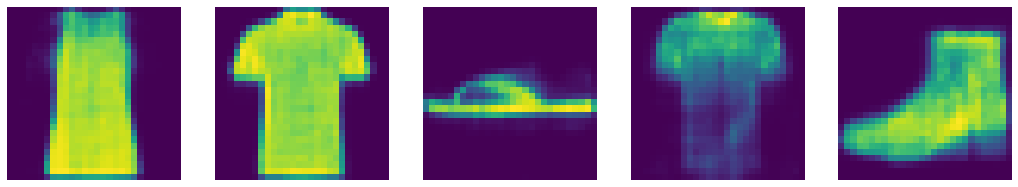

====> Epoch: 22 Average loss: 62.5389
====> Test set loss: 56.9331


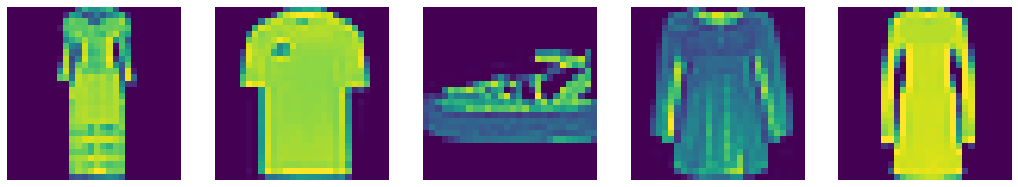

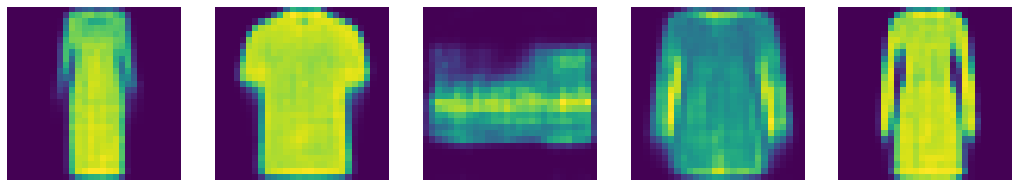

====> Epoch: 23 Average loss: 62.4753
====> Test set loss: 56.4733


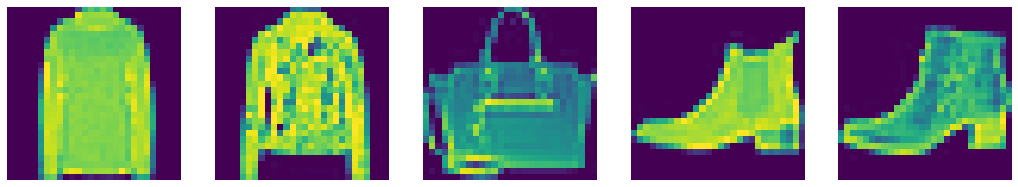

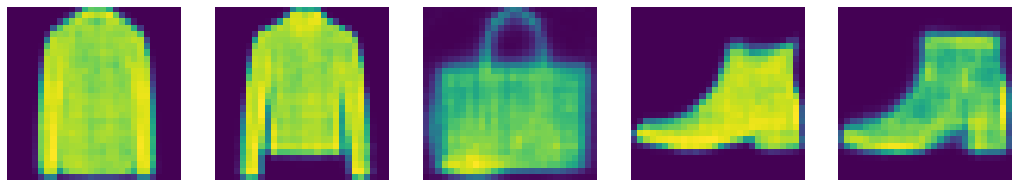

====> Epoch: 24 Average loss: 62.3118
====> Test set loss: 56.3475


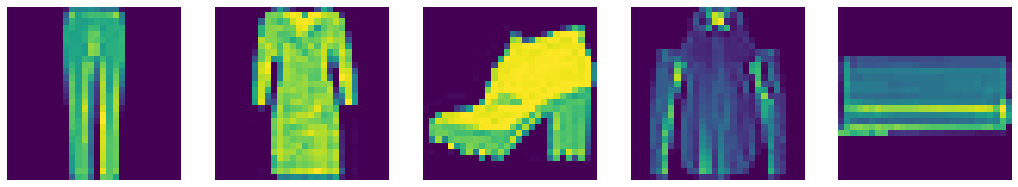

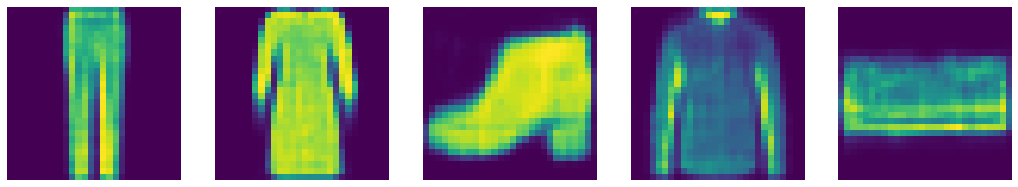

====> Epoch: 25 Average loss: 62.1562
====> Test set loss: 56.3198


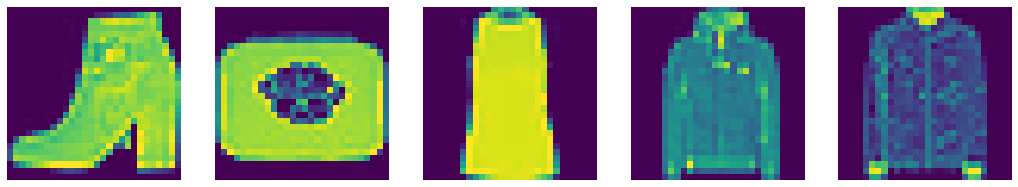

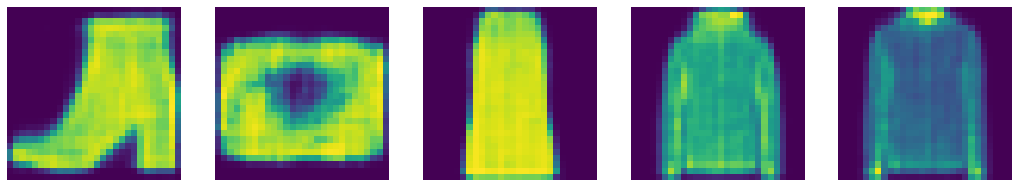

====> Epoch: 26 Average loss: 61.9947
====> Test set loss: 56.4785


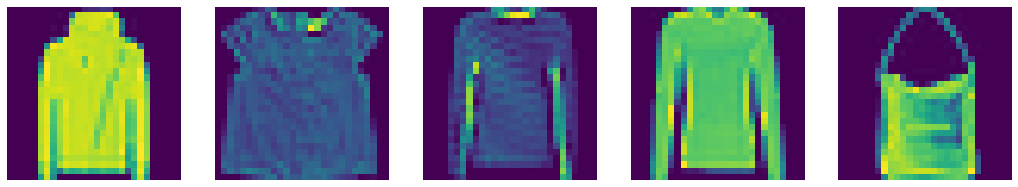

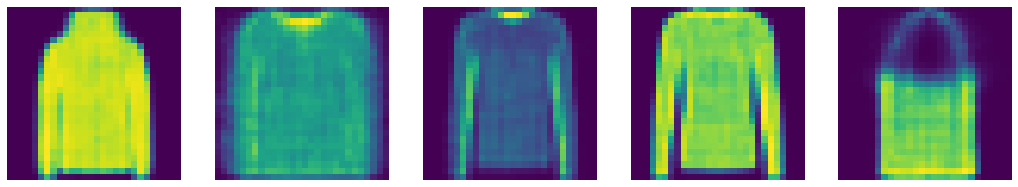

====> Epoch: 27 Average loss: 61.9477
====> Test set loss: 55.3531


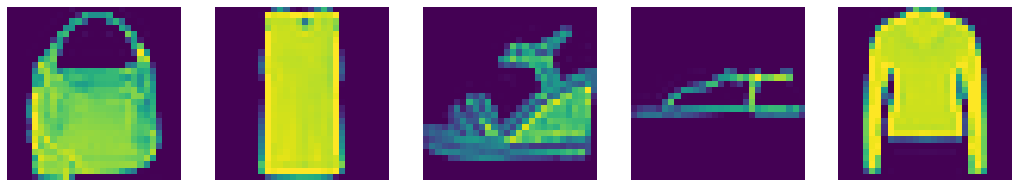

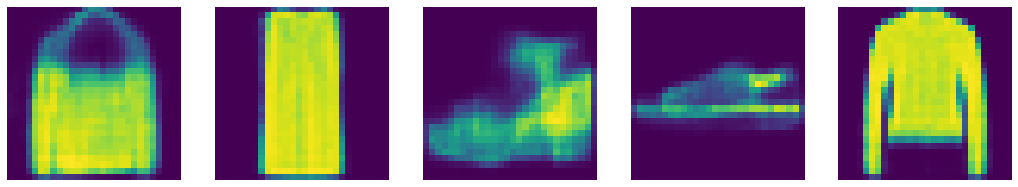

====> Epoch: 28 Average loss: 61.7981
====> Test set loss: 55.6932


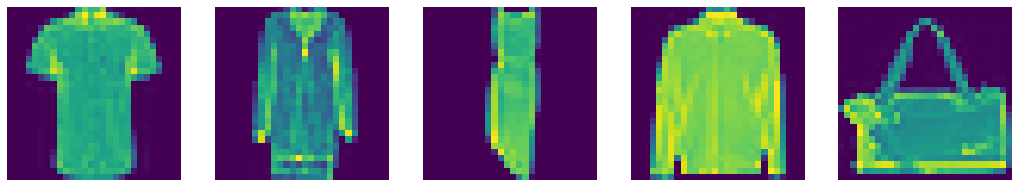

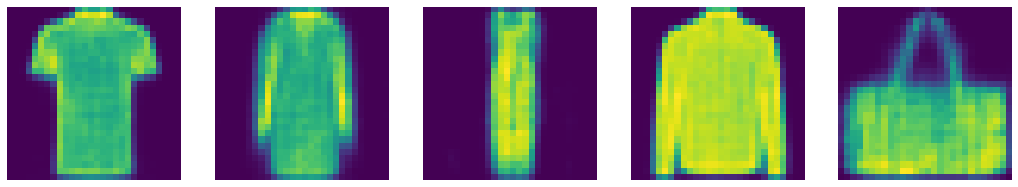

====> Epoch: 29 Average loss: 61.6795
====> Test set loss: 55.7013


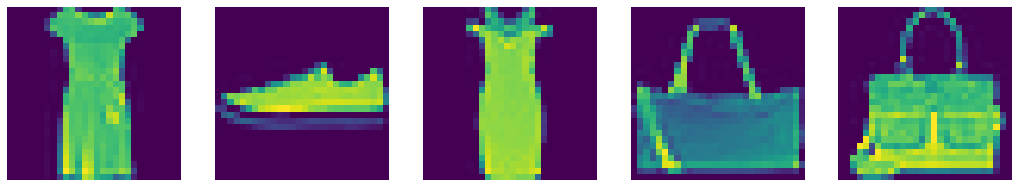

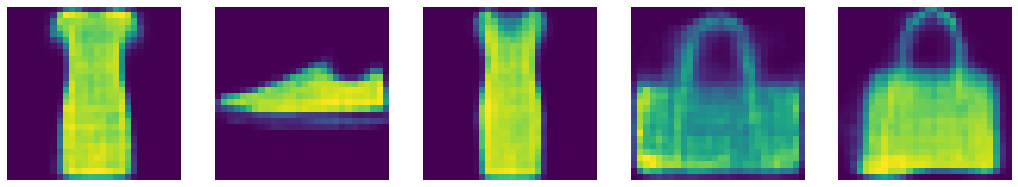

====> Epoch: 30 Average loss: 61.5500
====> Test set loss: 56.1658


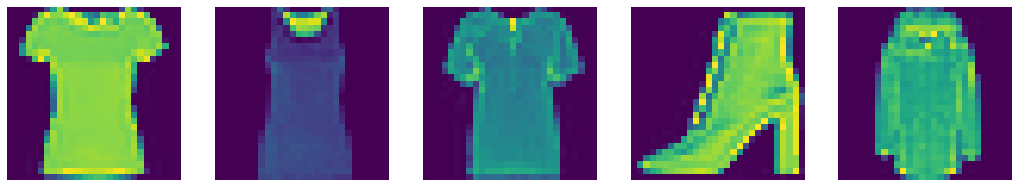

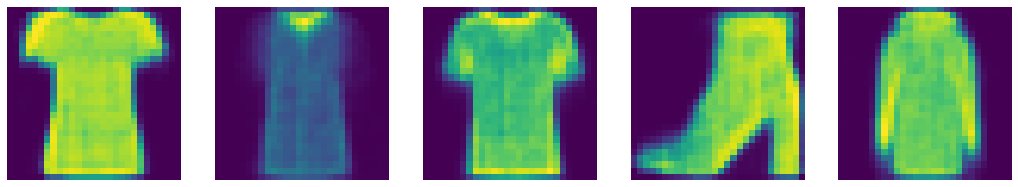

====> Epoch: 31 Average loss: 61.4636
====> Test set loss: 55.5299


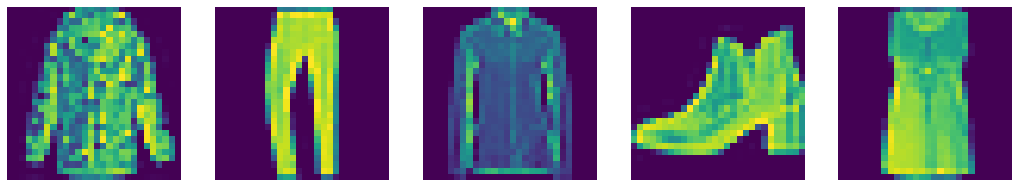

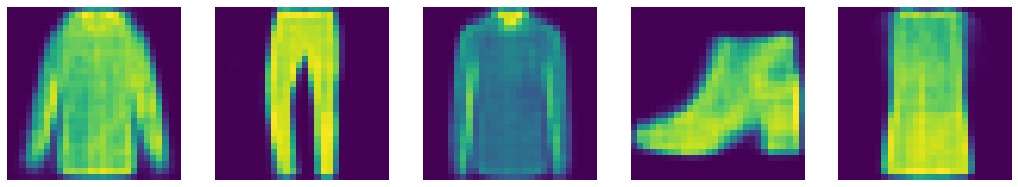

====> Epoch: 32 Average loss: 61.4008
====> Test set loss: 55.4603


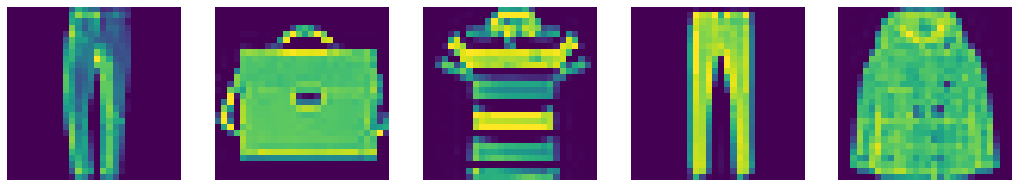

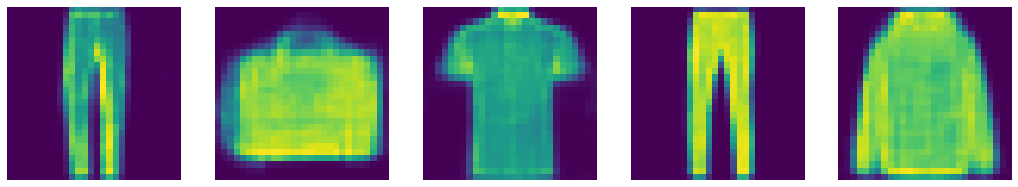

====> Epoch: 33 Average loss: 61.2510
====> Test set loss: 55.0324


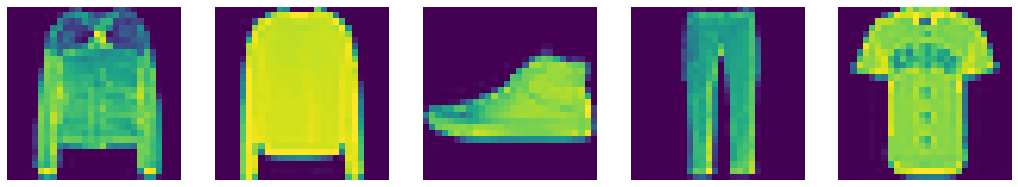

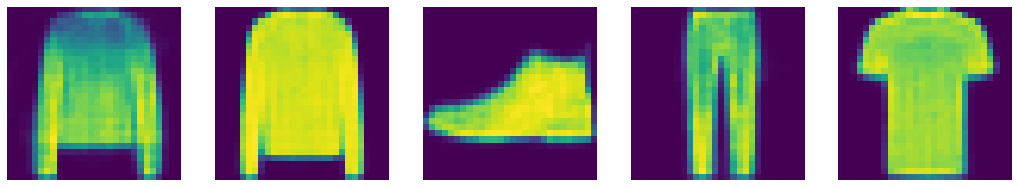

====> Epoch: 34 Average loss: 61.1985
====> Test set loss: 55.1678


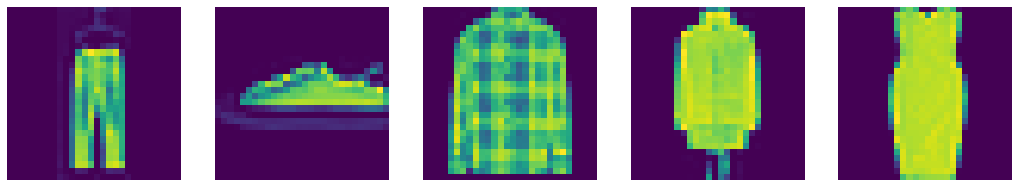

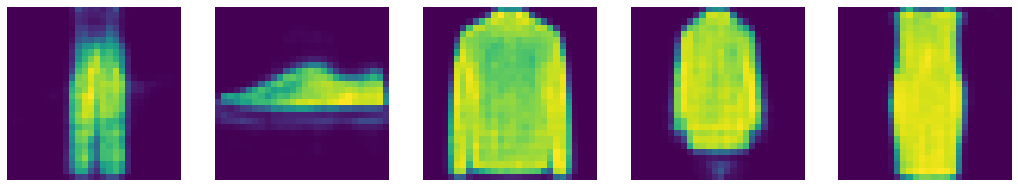

====> Epoch: 35 Average loss: 61.1004
====> Test set loss: 55.4098


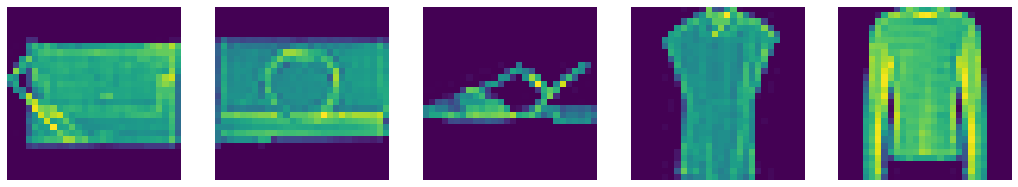

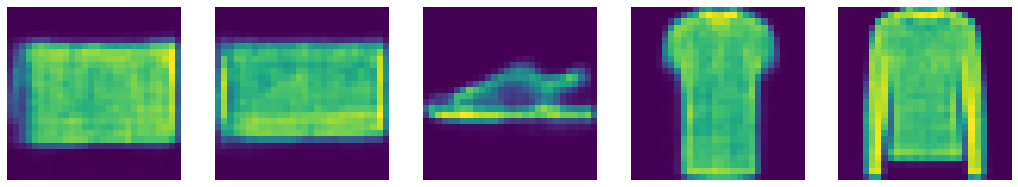

====> Epoch: 36 Average loss: 61.1509
====> Test set loss: 55.1145


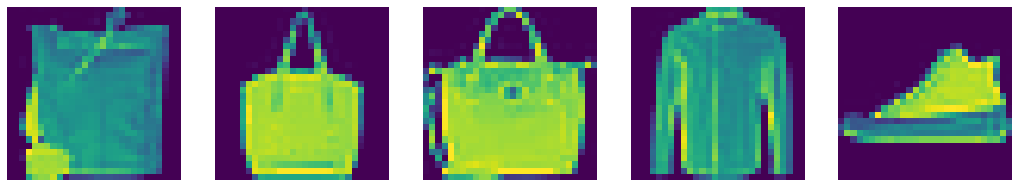

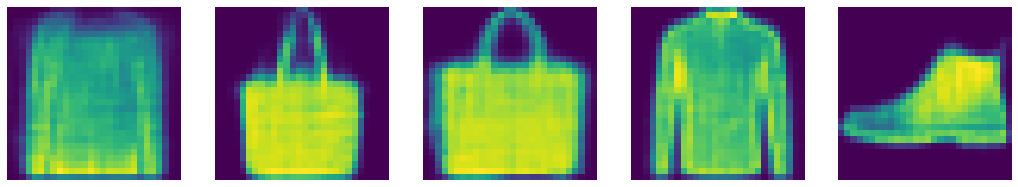

====> Epoch: 37 Average loss: 60.9401
====> Test set loss: 54.9426


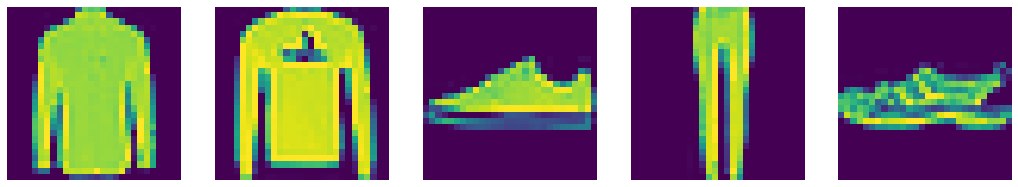

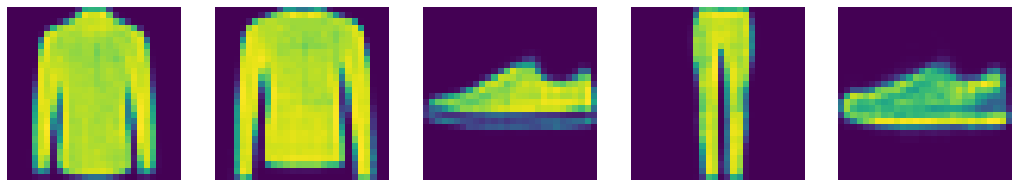

====> Epoch: 38 Average loss: 60.9013
====> Test set loss: 54.6311


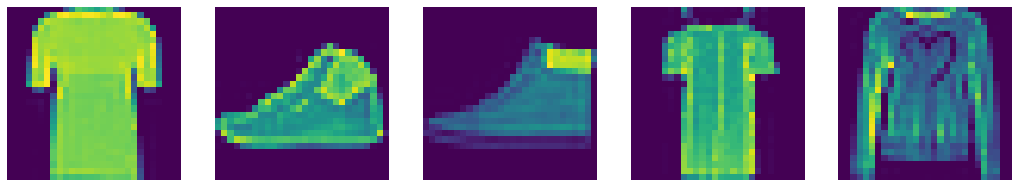

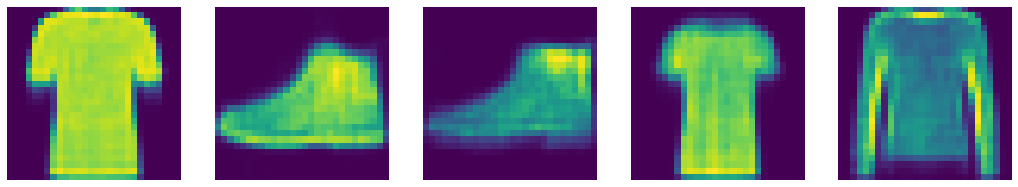

====> Epoch: 39 Average loss: 60.8456
====> Test set loss: 54.9397


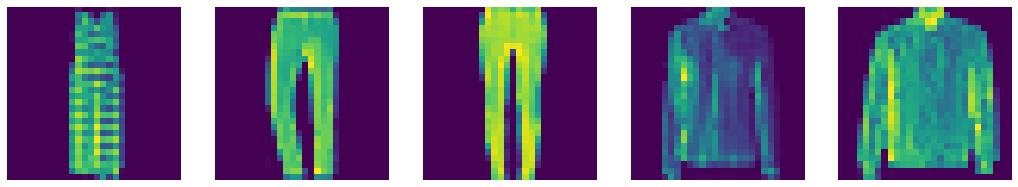

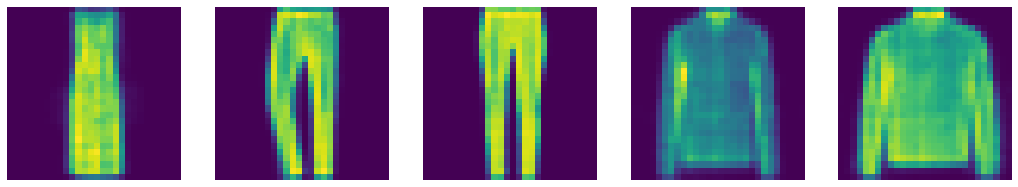

====> Epoch: 40 Average loss: 60.7739
====> Test set loss: 54.7021


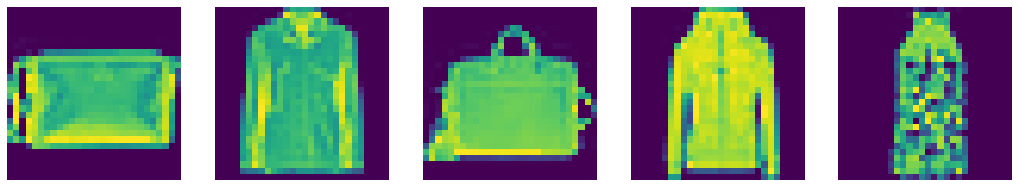

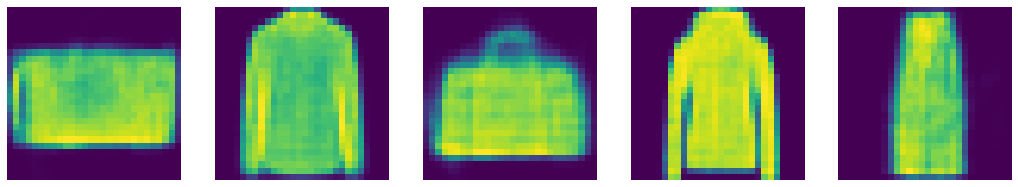

====> Epoch: 41 Average loss: 60.6801
====> Test set loss: 54.6860


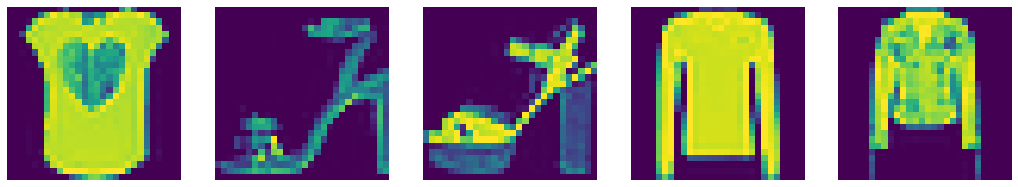

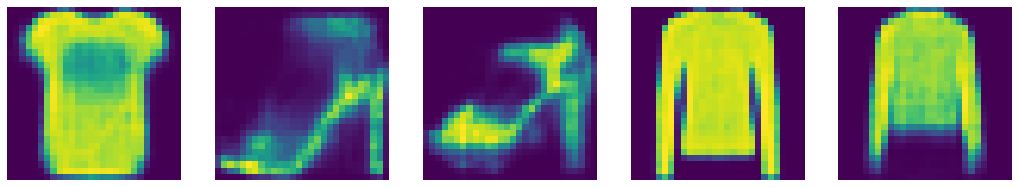

====> Epoch: 42 Average loss: 60.6065
====> Test set loss: 55.3160


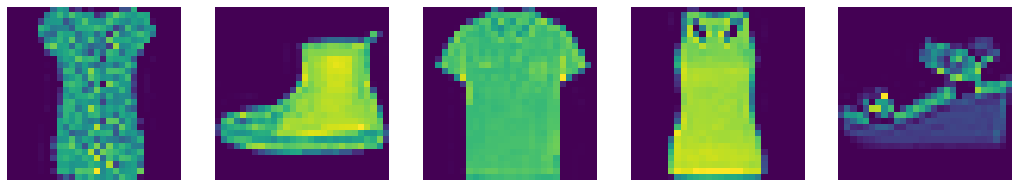

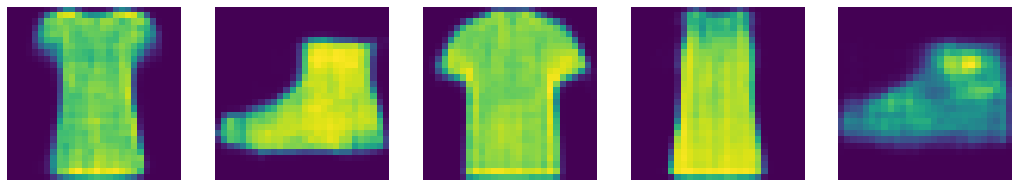

====> Epoch: 43 Average loss: 60.5150
====> Test set loss: 54.7589


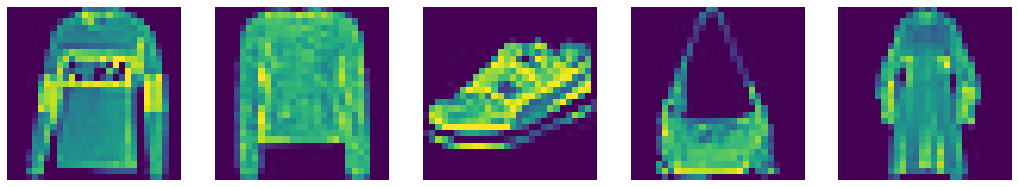

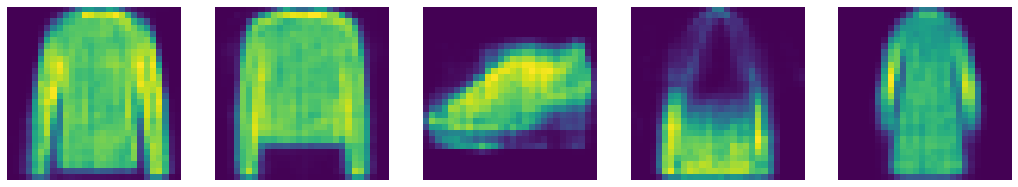

====> Epoch: 44 Average loss: 60.5212
====> Test set loss: 54.9173


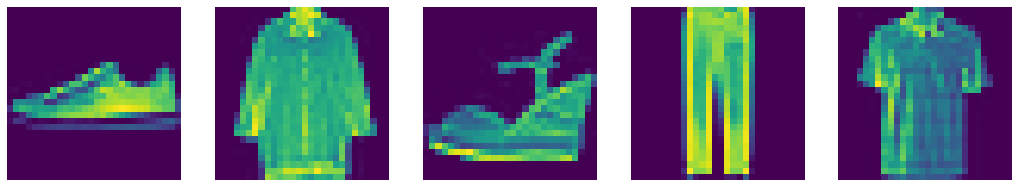

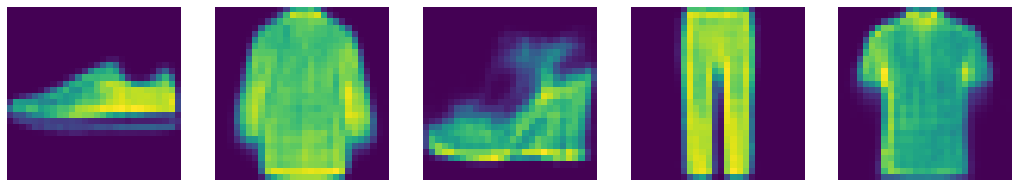

====> Epoch: 45 Average loss: 60.4192
====> Test set loss: 54.8824


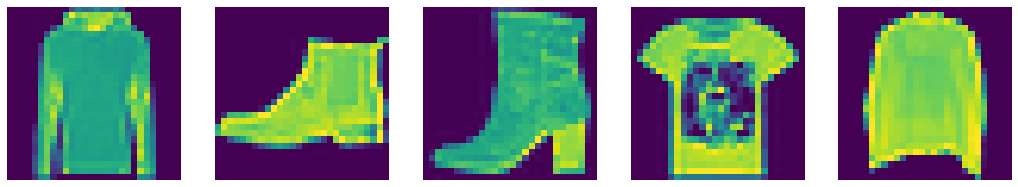

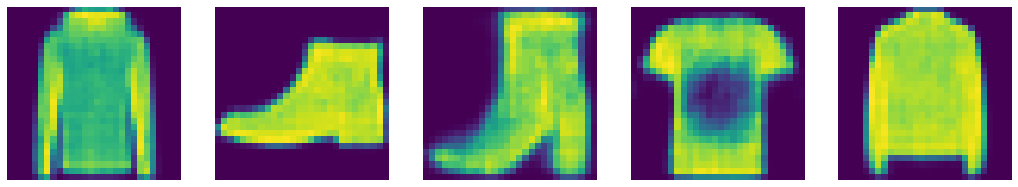

====> Epoch: 46 Average loss: 60.4076
====> Test set loss: 54.5743


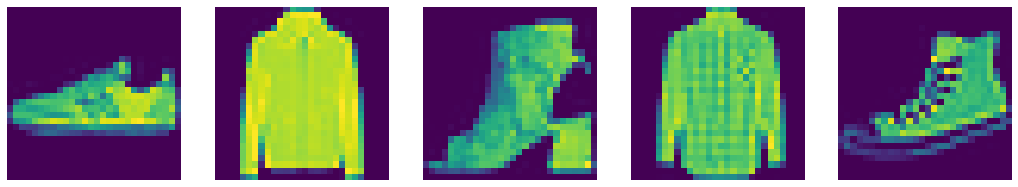

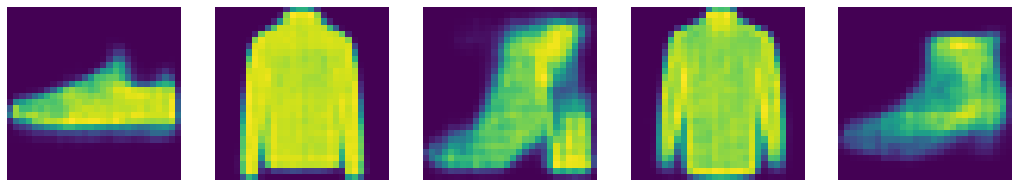

====> Epoch: 47 Average loss: 60.3611
====> Test set loss: 54.0818


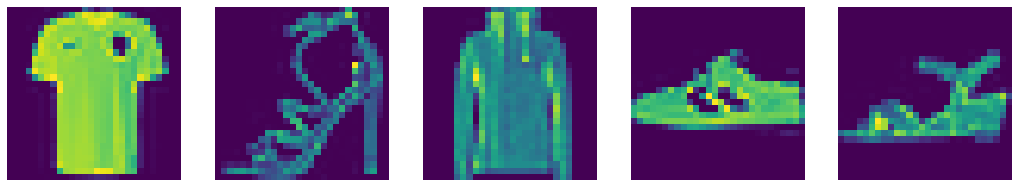

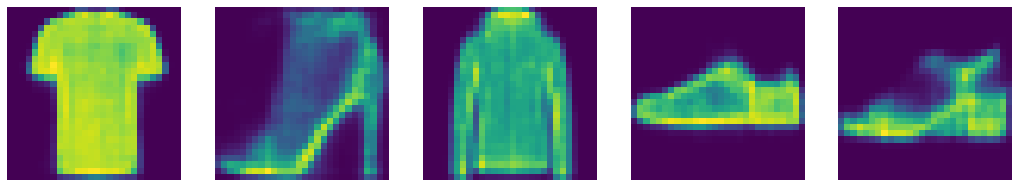

====> Epoch: 48 Average loss: 60.2671
====> Test set loss: 54.5430


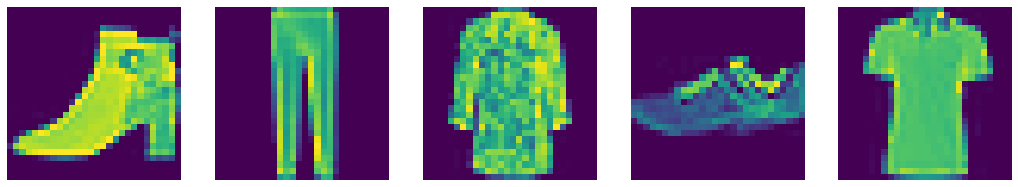

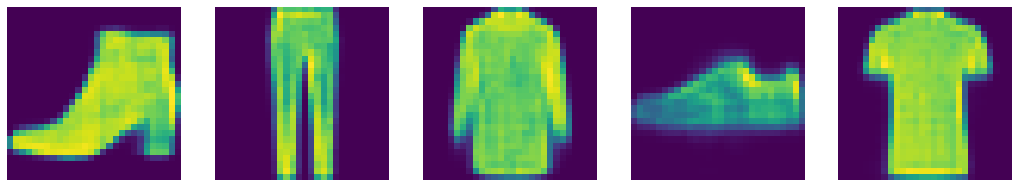

====> Epoch: 49 Average loss: 60.2119
====> Test set loss: 54.7748


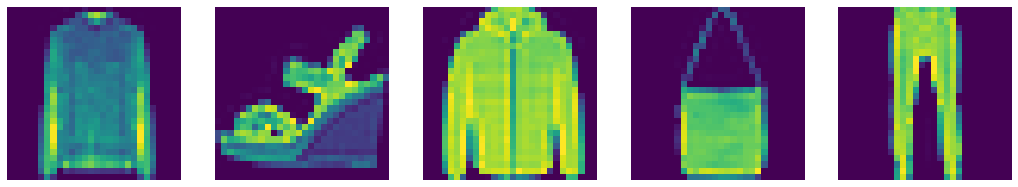

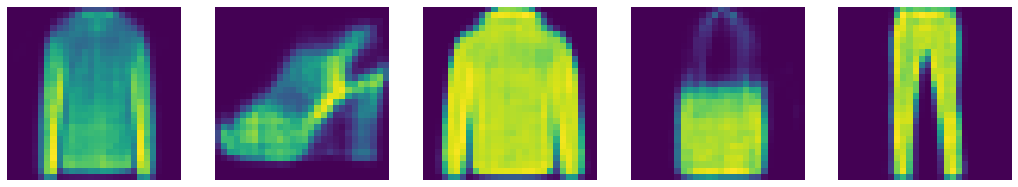

====> Epoch: 50 Average loss: 60.2047
====> Test set loss: 54.5600


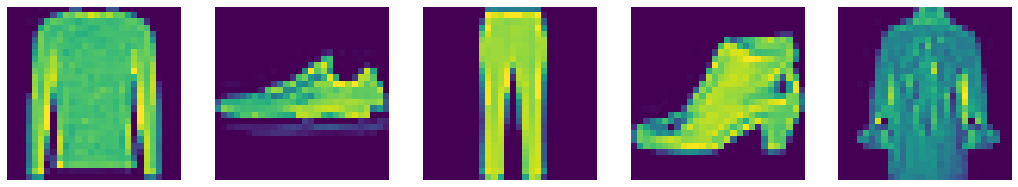

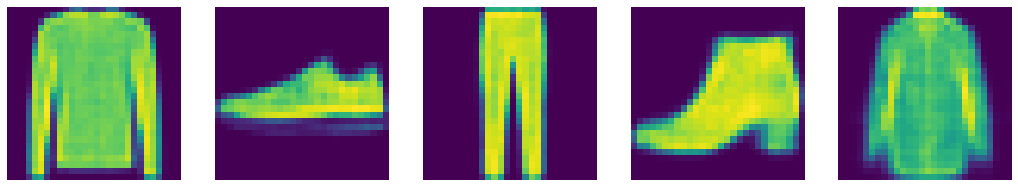

In [6]:
latent_dim=20
model = VAE(latent_dim).to(device)
loss_train=[]
loss_test=[]
# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 50
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            loss_train.append(train_loss)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            loss_test.append(test_loss)
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 5)

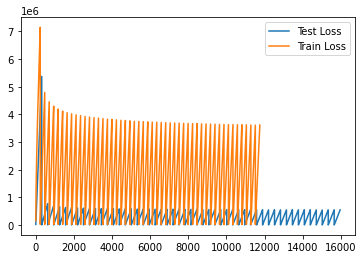

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_test,label="Test Loss")
plt.plot(loss_train,label="Train Loss")
plt.legend()

##2. Create a GAN for Fashion-MNIST. Show 10 images generated from random codewords

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from tqdm.notebook import tqdm_notebook
import time

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [9]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

### Loading the Data

In [10]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Resize(32),  
                       transforms.CenterCrop(32),
                   ])),
    batch_size=32, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=10, shuffle=True)

In [11]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Plotting one batch of images

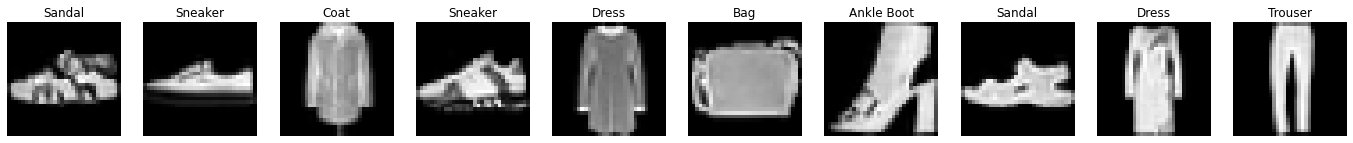

In [12]:
plt.figure(figsize=(24, 24))
train_image_batch, train_label_batch = next(iter(train_loader))
for i in range(10):
    image = train_image_batch[i]
    label = train_label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),cmap ="gray")
    plt.axis('off')
    plt.title(output_label(label))

In [13]:
train_image_batch[0].shape

torch.Size([1, 32, 32])

In [14]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x
    

In [15]:
img = train_image_batch[5]
print('Before scaling min: ', img.min())
print('Before scaling max: ', img.max())

scaled_img = scale_images(img)

print('After Scaling Min: ', scaled_img.min())
print('After Scaling Max: ', scaled_img.max())

Before scaling min:  tensor(0.)
Before scaling max:  tensor(0.9333)
After Scaling Min:  tensor(-1.)
After Scaling Max:  tensor(0.8665)


### convolutional Layer

In [16]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### Creating the Discriminator 

In [17]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(1, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*2*4)
        
        x = self.fc(x)
        
        
        return x

### Deconvolutional Channel

In [18]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### Creating the Generator

In [19]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)
        
        
        return x

### Initialising The Weights

In [20]:
def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [21]:
d_conv_dim = 64
g_conv_dim = 128
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


In [22]:
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [23]:
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


In [24]:
use_gpu = torch.cuda.is_available()

### Optimizers

In [25]:
lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr,(beta1,beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr,(beta1,beta2)) # for generator

### Defining the loss function

In [26]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

### Training The GAN

In [27]:
def train(D, G, n_epochs, train_on_gpu, print_every=100):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in tqdm_notebook(range(n_epochs)):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [28]:
start = time.time()
n_epochs = 10
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)
end = time.time()
print("time=  "+ str(end - start)+" sec")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [    1/   10] | d_loss: 4.0736 | g_loss: 2.3061
Epoch [    1/   10] | d_loss: 0.0272 | g_loss: 11.7500
Epoch [    1/   10] | d_loss: 0.0387 | g_loss: 10.7430
Epoch [    1/   10] | d_loss: 0.0253 | g_loss: 11.6173
Epoch [    1/   10] | d_loss: 0.0022 | g_loss: 10.1654
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 12.7175
Epoch [    1/   10] | d_loss: 0.0007 | g_loss: 12.0300
Epoch [    1/   10] | d_loss: 0.0026 | g_loss: 10.8643
Epoch [    1/   10] | d_loss: 0.0006 | g_loss: 10.7077
Epoch [    1/   10] | d_loss: 0.0008 | g_loss: 12.7171
Epoch [    1/   10] | d_loss: 0.0007 | g_loss: 10.9573
Epoch [    1/   10] | d_loss: 0.0021 | g_loss: 16.6041
Epoch [    1/   10] | d_loss: 0.0004 | g_loss: 12.5361
Epoch [    1/   10] | d_loss: 0.0020 | g_loss: 16.0339
Epoch [    1/   10] | d_loss: 0.0285 | g_loss: 5.4174
Epoch [    1/   10] | d_loss: 0.0085 | g_loss: 7.6057
Epoch [    1/   10] | d_loss: 0.0014 | g_loss: 12.6557
Epoch [    1/   10] | d_loss: 0.0081 | g_loss: 13.4973
Epoch [    1/

### Plotiing the loss function

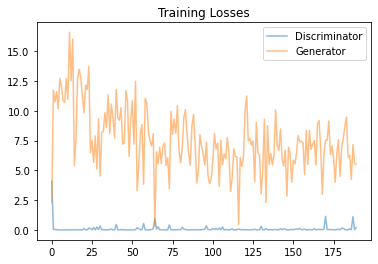

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [30]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

### Displaying images from different epoch

In [31]:
def view_samples(epoch,samples):
    plt.figure(figsize=(12, 5))
    batch=samples[epoch]
    for i in range(10):
        image = batch[i].detach().cpu()
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.squeeze().numpy(),cmap="gray")
        plt.axis('off')


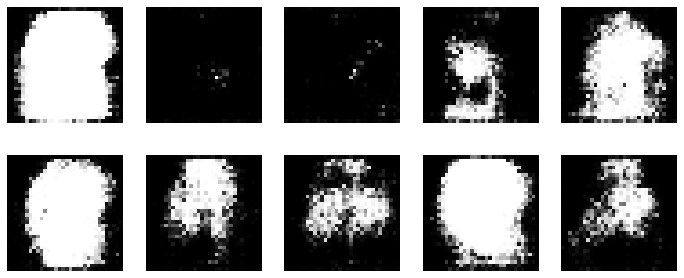

In [32]:
view_samples(0,samples)

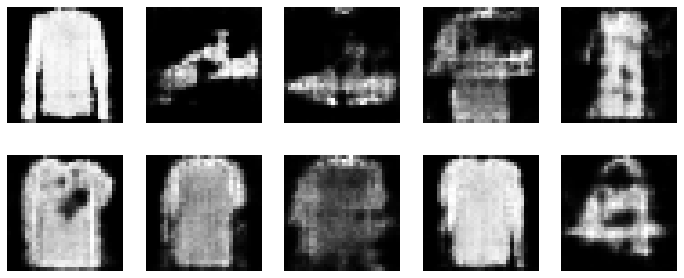

In [35]:
view_samples(5,samples)

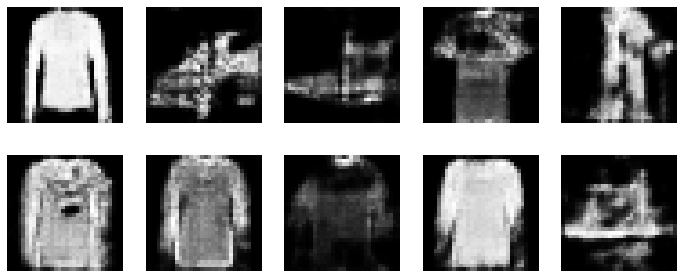

In [34]:
view_samples(9,samples)